In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import utilities

In [4]:
def plot_series(series, time=None, line='-', start=0, end=None, label=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    if time is None:
        time = range(len(series))
    ax.plot(time[start:end], series[start:end], line, label=label)
    utilities.set_ax(ax, xlabel='Time', legend=label is not None, grid=True)
    
def trend(time, slope=0):
    return slope * time

pattern = lambda t: np.where(t < 0.4, np.cos(2*np.pi*t), np.exp(-3*t))

def pattern2series(pattern, time, period, amp=1, phase=0):
    return amp*pattern((time/period + phase) % 1)

def noise(time, noise_std=1, rng=np.random.RandomState(0)):
    return rng.randn(len(time)) * noise_std

def autocor(time, lags, coefs, noise_std=1, ini=0, rng=np.random.RandomState(0)):
    maxlag = max(lags)
    s = rng.randn(maxlag + len(time)) * noise_std
    s[:maxlag] += ini
    for i in range(maxlag, maxlag + len(time)):
        s[i] += sum(c*s[i-lag]for lag, c in zip(lags, coefs))
    return s[maxlag:]

def autocor2(time, coef, noise_std=1, rng=np.random.RandomState(0)):
    s = rng.randn(len(time)) * noise_std
    for i in range(1, len(time)):
        s[i] += coef * s[i-1]
    return s

def impulse(time, num, amp=1, rng=np.random.RandomState(0)):
    ind = rng.choice(np.arange(len(time)), num, replace=False)
    s = np.zeros_like(time, dtype=np.float64)
    s[ind] += rng.rand(num) * amp
    return s

def autocor3(series, lagcoef):
    s = series.copy()
    for i, _ in enumerate(s):
        s[i] += sum(coef * s[i-lag] for lag, coef in lagcoef.items() if i >= lag)
    return s

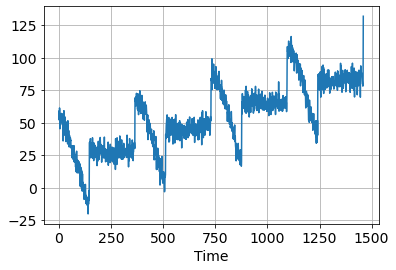

In [3]:
time = np.arange(4*365 + 1.)

baseline = 10
amp = 40
slope = 0.05
noise_std = 5

series = (baseline + trend(time, slope=slope)
          + pattern2series(pattern, time, period=365, amp=amp)
          + noise(time, noise_std=noise_std))

plot_series(series, time)

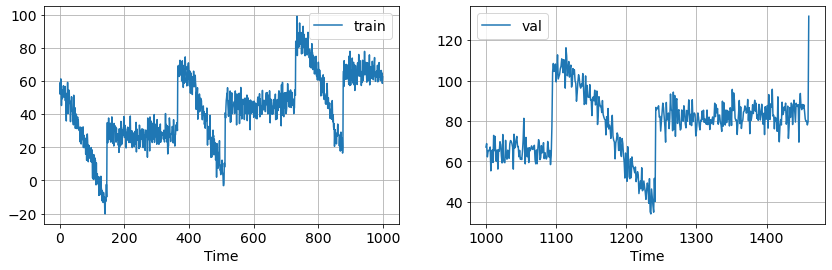

In [5]:
train_size = 1000

train_s, val_s = series[:train_size], series[train_size:]
train_t, val_t = time[:train_size], time[train_size:]

fig, axs = plt.subplots(1, 2, figsize=[14, 4])
plot_series(train_s, train_t, label='train', ax=axs[0])
plot_series(val_s, val_t, label='val', ax=axs[1])

In [82]:
def series2data(series, window, batch=1, buffer=None):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=window+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.shuffle(buffer_size=len(series) if buffer is None else buffer)
    ds = ds.batch(batch).prefetch(1)
    return ds

In [84]:
window = 20
batch = 32

train_data = series2data(train_s, window=window, batch=batch)
val_data = series2data(val_s, window=window, batch=batch)

for b in train_data.take(1):
    print(type(b), len(b))
    print(b[0].shape, b[1].shape)

<class 'tuple'> 2
(32, 20) (32,)


In [85]:
def fit_series(epochs, lr=1e-6, mom=0.9):
    model = keras.models.Sequential([
        keras.layers.Dense(1, input_shape=[window]),
    ])
    model.summary()
    
    model.compile(
        loss='mse',
        optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=mom),
    )
    
    history = model.fit(
        train_data, epochs=epochs, validation_data = val_data, verbose=0
    )
    utilities.plot_train_val_metrics(history, ['loss'])
    
    return model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
CPU times: total: 23.2 s
Wall time: 14 s


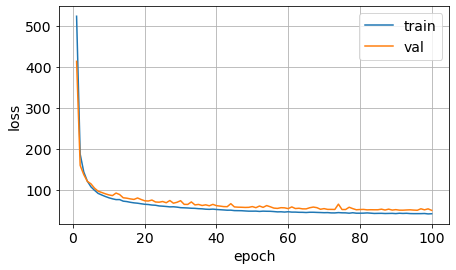

In [86]:
%%time
model = fit_series(epochs=100)

In [87]:
model.layers[0].get_weights()

[array([[-0.03951857],
        [ 0.07821988],
        [-0.01127999],
        [ 0.0207816 ],
        [-0.10609784],
        [ 0.02433333],
        [-0.0059814 ],
        [ 0.11356217],
        [-0.07401079],
        [ 0.03206434],
        [ 0.00336695],
        [-0.07923756],
        [-0.05454982],
        [ 0.1015315 ],
        [ 0.02304787],
        [ 0.06274211],
        [ 0.05767733],
        [ 0.15138648],
        [ 0.21494603],
        [ 0.4849847 ]], dtype=float32),
 array([0.01355294], dtype=float32)]

In [88]:
def plot_pred(model):
    full_data = series2data(series, window=window, batch=len(series)-window, buffer=1)
    data_x, data_y = [(x.numpy(), y.numpy()) for x, y in full_data][0]
    pred = model.predict(data_x).squeeze()
    fig, ax = plt.subplots()
    ax.axvline(time[train_size], c='r')
    plot_series(np.c_[series[window:], pred], time[window:], ax=ax,
                label=['truth', '1-layer nn'])

    t_trn, t_val = time[window:train_size], time[train_size:]
    s_trn, s_val = series[window:train_size], series[train_size:]
    pred_trn, pred_val = pred[:train_size-window], pred[train_size-window:]

    rmse_trn = np.sqrt(keras.metrics.mean_squared_error(s_trn, pred_trn))
    mae_trn = keras.metrics.mean_absolute_error(s_trn, pred_trn)

    rmse_val = np.sqrt(keras.metrics.mean_squared_error(s_val, pred_val))
    mae_val = keras.metrics.mean_absolute_error(s_val, pred_val)

    fig, axs = plt.subplots(1, 2, figsize=[14, 4])
    plot_series(np.c_[s_trn, pred_trn], t_trn, ax=axs[0],
                label=('truth', f'1-layer nn, rmse={rmse_trn:.3g}, mae={mae_trn:.3g}'))
    plot_series(np.c_[s_val, pred_val], t_val, ax=axs[1],
                label=('truth', f'1-layer nn, rmse={rmse_val:.3g}, mae={mae_val:.3g}'))

46/46 [==============================] - 0s 692us/step


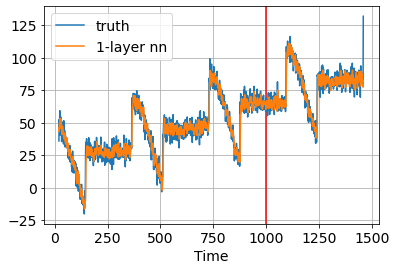

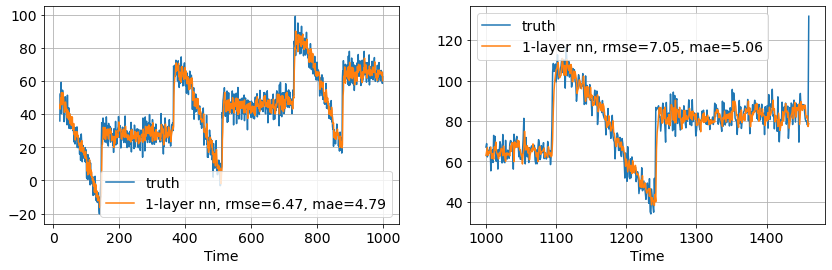

In [89]:
plot_pred(model)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
46/46 [==============================] - 0s 490us/step
CPU times: total: 4.61 s
Wall time: 3.16 s


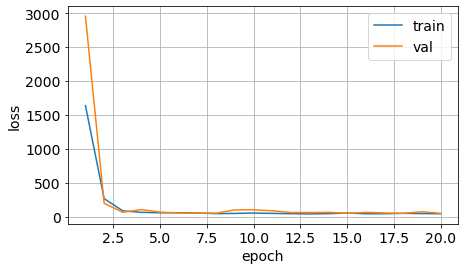

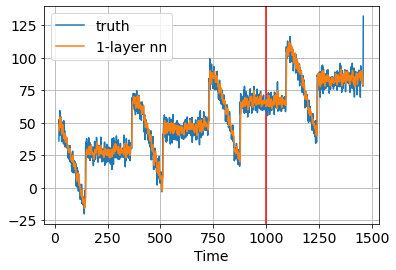

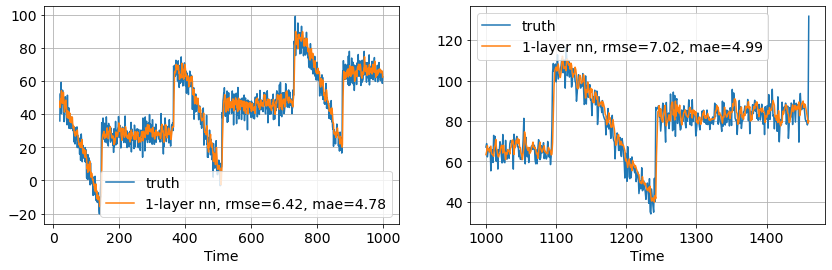

In [91]:
%%time
model = fit_series(epochs=20, lr=1e-5)
plot_pred(model)

In [119]:
def fit_series_dnn(epochs, lr=1e-6, mom=0.9):
    model = keras.models.Sequential([
        keras.layers.Dense(10, activation='relu', input_shape=[window]),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(1),
    ])
    model.summary()
    
    model.compile(
        loss='mse',
        optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=mom),
    )
    
    history = model.fit(
        train_data, epochs=epochs, validation_data = val_data, verbose=0
    )
    utilities.plot_train_val_metrics(history, ['loss'])
    plot_pred(model)
    
    return model, history

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 10)                210       
                                                                 
 dense_55 (Dense)            (None, 10)                110       
                                                                 
 dense_56 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
46/46 [==============================] - 0s 694us/step
CPU times: total: 2min 12s
Wall time: 1min 25s


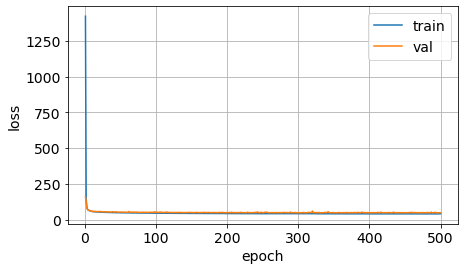

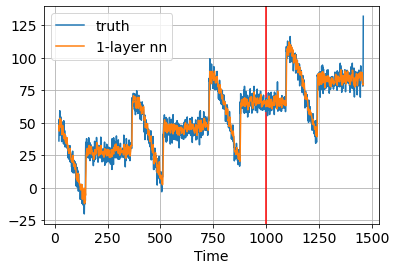

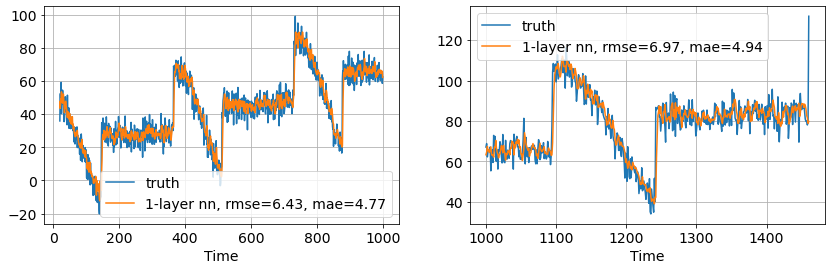

In [123]:
%%time
model, history = fit_series_dnn(epochs=500)

(48.93593978881836, 6.995422774130121)

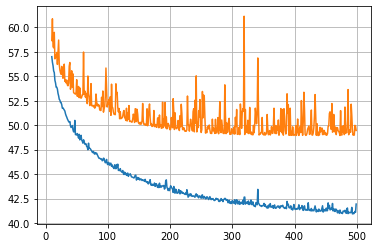

In [130]:
plt.plot(history.epoch[10:], history.history['loss'][10:])
plt.plot(history.epoch[10:], history.history['val_loss'][10:])
plt.grid()
min(history.history['val_loss']), np.sqrt(min(history.history['val_loss']))

In [114]:
def fit_series_tunelr(epochs, mom=0.9):
    model = keras.models.Sequential([
        keras.layers.Dense(10, activation='relu', input_shape=[window]),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(1),
    ])
    model.summary()
    
    model.compile(
        loss='mse',
        optimizer=keras.optimizers.SGD(momentum=mom),
    )
    
    ep2lr = lambda epoch: 1e-8 * 10**(epoch/20)
    lr_schd = keras.callbacks.LearningRateScheduler(ep2lr)
    
    history = model.fit(
        train_data, epochs=epochs, validation_data = val_data, verbose=0,
        callbacks=[lr_schd]
    )
    
    fig, ax = plt.subplots(figsize=[10, 4])
    ax.semilogx(ep2lr(np.arange(epochs)), history.history['loss'])
    ax.set_ylim([0, 300])
    utilities.set_ax(ax, xlabel='learning rate', title='mse loss', grid=True)
    
    return model, history

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 10)                210       
                                                                 
 dense_34 (Dense)            (None, 10)                110       
                                                                 
 dense_35 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
CPU times: total: 25.7 s
Wall time: 17.3 s


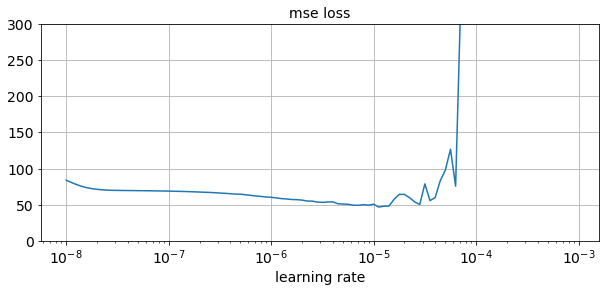

In [115]:
%%time
model, history = fit_series_tunelr(100)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 10)                210       
                                                                 
 dense_46 (Dense)            (None, 10)                110       
                                                                 
 dense_47 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
46/46 [==============================] - 0s 1ms/step


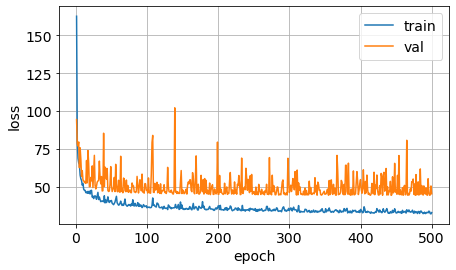

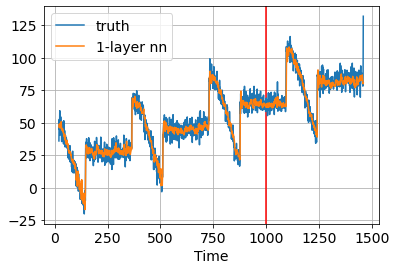

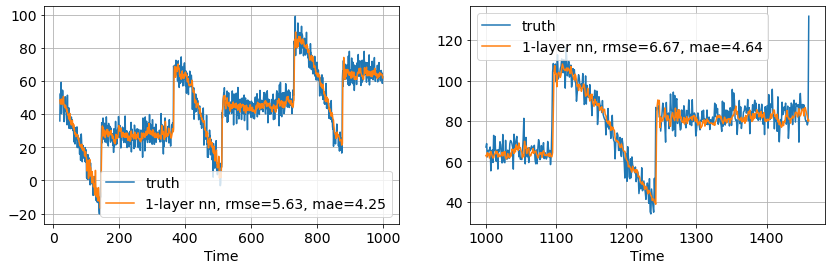

In [120]:
model, history = fit_series_dnn(epochs=500, lr=4e-6)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 10)                210       
                                                                 
 dense_49 (Dense)            (None, 10)                110       
                                                                 
 dense_50 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
46/46 [==============================] - 0s 830us/step


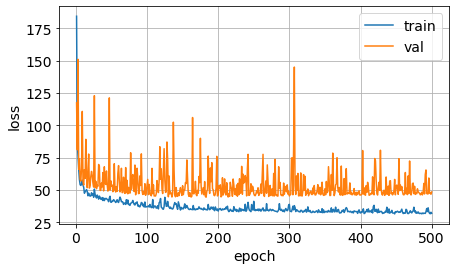

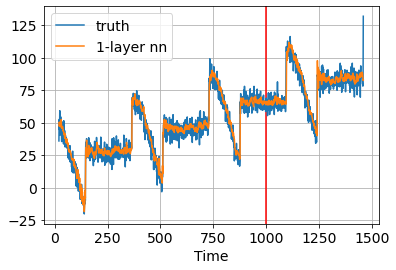

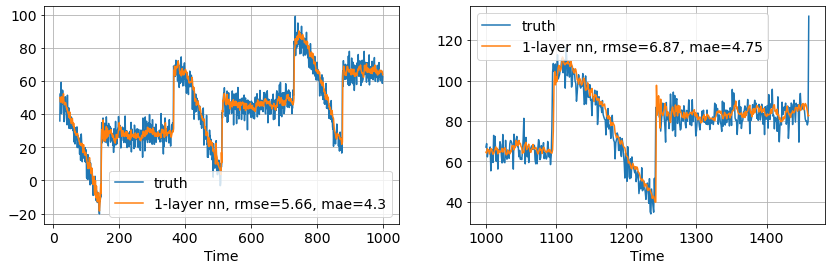

In [121]:
model, history2 = fit_series_dnn(epochs=500, lr=1e-5)

In [128]:
min(history2.history['val_loss']), np.sqrt(min(history2.history['val_loss']))

(44.32307434082031, 6.657557685880034)